<b>DiaObject / TruthSummary Catalog Matching</b> <br>
Contact author: Douglas Tucker <br>
Last verified to run: 2022-12-08<br>
LSST Science Piplines version: Weekly 2022_40 <br>
Container Size: medium <br>
Targeted learning level: intermediate <br>

**Description:** To use the astropy function `match_coordinates_sky` for fast sky-coordinate matching between a catalog from the DP0.2 DiaObject table and a catalog from the DP0.2 TruthSummary table.

**Skills:** Use the astropy function `match_coordinates_sky` for fast sky-coordinate matching between a catalog from the DP0.2 DiaObject table and a catalog from the DP0.2 TruthSummary table.

**LSST Data Products:** TAP tables dp02_dc2_catalogs.DiaObject, DiaSource, and TruthSummary.

**Packages:** lsst.rsp, astropy.cosmology, numpy, matplotlib, astropy.coordinates

**Credit:** The material for identifying candidate SNeIa from the DiaObject and DiaSource tables was developed by Melissa Graham for the DP0.2 Tutorial Notebook <a href="https://github.com/rubin-dp0/tutorial-notebooks/blob/main/07a_DiaObject_Samples.ipynb">07a_DiaObject_Samples.ipynb</a>.

**Get Support:**
Find DP0-related documentation and resources at <a href="https://dp0-2.lsst.io">dp0-2.lsst.io</a>. Questions are welcome as new topics in the <a href="https://community.lsst.org/c/support/dp0">Support - Data Preview 0 Category</a> of the Rubin Community Forum. Rubin staff will respond to all questions posted there.

## 1. Setup

Import packages.

In [1]:
import time
from IPython.display import Image

import math
from astropy.units import UnitsWarning
from astropy.coordinates import SkyCoord
from astropy.coordinates import match_coordinates_sky
import astropy.units as u
from astropy.table import Table
import pandas as pd
import numpy
import matplotlib.pyplot as plt

from lsst.rsp import get_tap_service

from astropy.cosmology import FlatLambdaCDM

Set plotting parameters.

In [2]:
plt.style.use('tableau-colorblind10')

Set the cosmology to use with the astropy.cosmology package.

In [3]:
cosmo = FlatLambdaCDM(H0=70, Om0=0.3)

Set identification parameters for candidate 0.1 < z 0.3 SNeIa, per DP0.2 Tutorial Notebook <a href="https://github.com/rubin-dp0/tutorial-notebooks/blob/main/07a_DiaObject_Samples.ipynb">07a_DiaObject_Samples.ipynb</a>.

In [4]:
redshift_min = 0.1
redshift_max = 0.3

snia_peak_mag = -19.0
snia_peak_mag_range = 0.5

snia_peak_mr_min = cosmo.distmod(redshift_min).value + snia_peak_mag - snia_peak_mag_range
snia_peak_mr_max = cosmo.distmod(redshift_max).value + snia_peak_mag + snia_peak_mag_range

snia_peak_mg_max = 24.0
snia_peak_mi_max = 24.0

snia_ampl_mr_min = 1.5
snia_ampl_mr_max = 5.5

snia_nDiaSources_min = 15
snia_nDiaSources_max = 100

snia_duration_min = 50
snia_duration_max = 300

Start the TAP service.

In [5]:
service = get_tap_service()

## 2.  Do Candidate SNe Ia from the DiaObject table have suitable matches in the TruthSummary table?

### 2.1. Retrieve a sample of potentially SNIa-like DiaObjects


Again, this follows the methodolody of the DP0.2 Tutorial Notebook <a href="https://github.com/rubin-dp0/tutorial-notebooks/blob/main/07a_DiaObject_Samples.ipynb">07a_DiaObject_Samples.ipynb</a>, except we are **not** retricting the query to the first 1000 entries returned.

The following cell typically takes much less than a minute.

In [6]:
%%time

results = service.search("SELECT ra, decl, diaObjectId, nDiaSources, "
                         "scisql_nanojanskyToAbMag(rPSFluxMin) AS rMagMax, "
                         "scisql_nanojanskyToAbMag(rPSFluxMax) AS rMagMin, "
                         "scisql_nanojanskyToAbMag(gPSFluxMax) AS gMagMin, "
                         "scisql_nanojanskyToAbMag(iPSFluxMax) AS iMagMin, "
                         "scisql_nanojanskyToAbMag(rPSFluxMin)"
                         " - scisql_nanojanskyToAbMag(rPSFluxMax) AS rMagAmp "
                         "FROM dp02_dc2_catalogs.DiaObject "
                         "WHERE nDiaSources > "+str(snia_nDiaSources_min)+" "
                         "AND nDiaSources < "+str(snia_nDiaSources_max)+" "
                         "AND scisql_nanojanskyToAbMag(rPSFluxMax) > "+str(snia_peak_mr_min)+" "
                         "AND scisql_nanojanskyToAbMag(rPSFluxMax) < "+str(snia_peak_mr_max)+" "
                         "AND scisql_nanojanskyToAbMag(gPSFluxMax) < "+str(snia_peak_mg_max)+" "
                         "AND scisql_nanojanskyToAbMag(iPSFluxMax) < "+str(snia_peak_mi_max)+" "
                         "AND scisql_nanojanskyToAbMag(rPSFluxMin)"
                         " - scisql_nanojanskyToAbMag(rPSFluxMax) < "+str(snia_ampl_mr_max)+" "
                         "AND scisql_nanojanskyToAbMag(rPSFluxMin)"
                         " - scisql_nanojanskyToAbMag(rPSFluxMax) > "+str(snia_ampl_mr_min)+" ")

DiaObjs = results.to_table()
del results

CPU times: user 172 ms, sys: 3.67 ms, total: 176 ms
Wall time: 7.47 s


Note that we found 6570 DiaObjects over the entire DP0.2 footprint that meet the above criteria.

In [7]:
DiaObjs

ra,decl,diaObjectId,nDiaSources,rMagMax,rMagMin,gMagMin,iMagMin,rMagAmp
deg,deg,,,,,,,
float64,float64,int64,int64,float64,float64,float64,float64,float64
52.2470842,-44.4958541,1249106781804691571,78,21.5179796816561,18.9861656189452,15.5560375755291,17.36419795848517,2.5318140627109003
51.9998072,-44.5730532,1249115577897713874,84,22.777275738832635,20.60976776051021,21.589895146270685,21.635413445386092,2.1675079783224263
51.8982033,-44.6035652,1249115577897714360,75,24.683969199238287,21.70144541441289,22.80936791860333,22.186450571344352,2.9825237848253963
51.8982033,-44.6035652,1248631792781493090,75,24.683969199238287,21.70144541441289,22.80936791860333,22.186450571344352,2.9825237848253963
52.9989517,-44.0892561,1249212334920958469,16,23.77055169313943,21.72253122833574,21.520279140677232,19.337516610478758,2.0480204648036917
53.0435514,-44.0320362,1249203538827938433,22,22.87782569710174,21.246428343680588,22.687840878318404,21.754937519257652,1.6313973534211534
53.3755908,-44.3309472,1249133170083758400,34,23.44509266861266,19.05394328157174,20.12780909953217,18.075152149280555,4.391149387040919
52.7493854,-43.9666417,1249273907572113641,21,23.56673116036134,21.387832156207693,20.40105877226395,22.772603010622134,2.178899004153646


### 2.1. Calculate lightcurve duration and identify potential SNIa

The lightcurve duration -- time between the first and last detected DiaSource in any filter -- is not included in the DiaObject table.
It is calculated below, using all of the DiaSources for each DiaObject.

Time is reported in the DiaSource table as `midPointTai`, which is in the SI unit of "TAI" (<a href="https://en.wikipedia.org/wiki/International_Atomic_Time">International Atomic Time</a>), and is presented in days (in particular, as "<a href="https://en.wikipedia.org/wiki/Julian_day">Modified Julian Days</a>").

Here we deviate slightly from the current (2022-10-25) version of <a href="https://github.com/rubin-dp0/tutorial-notebooks/blob/main/07a_DiaObject_Samples.ipynb">07a_DiaObject_Samples.ipynb</a>, using a combination of the ADQL `WHERE IN` command plus some `pandas`-based manipulations to achieve the same results.  (Kudos to Fritz Mueller of the Data Management Team who pointed out the speedy `WHERE IN` command in response to the <a href="https://community.lsst.org/t/query-objects-providing-a-list-of-ids/7256">Community Forum Post 7256</a>.)

First, create a list of diaObjectIds:

In [8]:
diaObjectId_list = DiaObjs['diaObjectId'].tolist()

Next, convert this python list into a string containing the comma-separated list of diaObjectId's:

In [9]:
diaObjectId_list_str = ','.join(map(str,diaObjectId_list))

Now we can query for the `midPointTai` timestamp for all the DiaSources associated with the DiaObject.  This cell typically takes about 1 minute to run.

In [10]:
%%time

query = """
        SELECT diaObjectId, midPointTai 
        FROM dp02_dc2_catalogs.DiaSource 
        WHERE diaObjectId IN (%s)
        """ % (diaObjectId_list_str)

#print(query)

results = service.search(query)

df_tmp = results.to_table().to_pandas()

del results

CPU times: user 1.32 s, sys: 20.2 ms, total: 1.34 s
Wall time: 32.4 s


_Optional:_  Take a quick look at the results from this query.  There are typically many `midPointTai`'s -- one per DiaSource for that DiaObject -- for each `diaObjectId`:

In [11]:
#df_tmp

We can use the pandas `groupby` function to find the earliest and latest `midPointTai` associated with each diaObject.  We can either estimate the duration for each diaObject by subtracting the minimum `midPointTai` from the maximum `midPointTai` for that diaObject, or by using the numpy `ptp` function to find the range of `midPointTai`'s for each diaObject.

In [12]:
df_tmp1 = df_tmp.groupby("diaObjectId")['midPointTai'].agg(["min", "max", numpy.ptp])
df_tmp1['duration'] = df_tmp1['max'] - df_tmp1['min']
df_tmp1.reset_index(inplace=True)
df_tmp1

,diaObjectId,min,max,ptp,duration
0,1248631792781492252,59822.287166,61396.057214,1573.770048,1573.770048
1,1248631792781492328,59822.405489,61387.071226,1564.665737,1564.665737
2,1248631792781492405,59853.242728,61396.038048,1542.795320,1542.795320
3,1248631792781493090,60701.141724,61396.056262,694.914538,694.914538
4,1248649384967537163,60162.389818,61387.071226,1224.681408,1224.681408
...,...,...,...,...,...
6565,2187342044018507960,60695.184236,61389.125179,693.940943,693.940943
6566,2187350840111530104,60737.009985,61389.109924,652.099939,652.099939
6567,2187359636204552197,60584.266144,61394.216612,809.950468,809.950468
6568,2187359636204552255,60684.115289,61389.125179,705.009890,705.009890


Let's convert the DiaObjs Table to a pandas DataFrame:

In [13]:
df_DiaObjs = DiaObjs.to_pandas()

We will now merge the `df_DiaObjs` DataFrame with the the `df_tmp1` DataFrame by their `diaObjectId`'s.  Now, we have all the info we need for each diaObject. Note that the contents of the `ptp` column are the same as the manually generated contents of the `duration` column.

In [14]:
df_DiaObjs_new = pd.merge(df_DiaObjs, df_tmp1, on='diaObjectId', how='inner')
df_DiaObjs_new

,ra,decl,diaObjectId,nDiaSources,rMagMax,rMagMin,gMagMin,iMagMin,rMagAmp,min,max,ptp,duration
0,52.247084,-44.495854,1249106781804691571,78,21.517980,18.986166,15.556038,17.364198,2.531814,59832.270266,61371.261271,1538.991005,1538.991005
1,51.999807,-44.573053,1249115577897713874,84,22.777276,20.609768,21.589895,21.635413,2.167508,59867.295381,61396.057214,1528.761833,1528.761833
2,51.898203,-44.603565,1249115577897714360,75,24.683969,21.701445,22.809368,22.186451,2.982524,60701.141724,61396.056262,694.914538,694.914538
3,51.898203,-44.603565,1248631792781493090,75,24.683969,21.701445,22.809368,22.186451,2.982524,60701.141724,61396.056262,694.914538,694.914538
4,52.998952,-44.089256,1249212334920958469,16,23.770552,21.722531,21.520279,19.337517,2.048020,59835.400012,61396.056262,1560.656250,1560.656250
...,...,...,...,...,...,...,...,...,...,...,...,...,...
6565,67.882067,-43.501771,1252396520594997512,19,21.897687,19.408658,21.580845,19.178419,2.489029,59634.050900,61406.040858,1771.989958,1771.989958
6566,67.828310,-43.508609,1252396520594997720,23,24.296324,21.474614,22.923381,22.513807,2.821709,59822.292969,61331.185659,1508.892690,1508.892690
6567,68.049235,-43.867588,1252264579199664289,21,21.979987,20.065309,19.484806,18.420675,1.914678,59603.031123,61311.369746,1708.338623,1708.338623
6568,67.823060,-43.810502,1252273375292686801,26,20.698992,18.927164,18.517678,18.277849,1.771829,59805.342742,61364.195015,1558.852273,1558.852273


Now, let us select only DiaObjects in the `df_DiaObjs_new` DataFrame that have lightcurve durations within the specified range for SNIa.  Note, there are 331 candidate SNeIa that meet these criteria over the whole area and time period of the DP0.2 (simulated) observations.

**These 331 candidate SNe Ia compose the sample we wish to match with the TruthSummary table.**

In [15]:
mask = (df_DiaObjs_new['duration'] > snia_duration_min) & (df_DiaObjs_new['duration'] < snia_duration_max)
df_DiaObjs_cand_SNeIa = df_DiaObjs_new[mask].copy(deep=True)
df_DiaObjs_cand_SNeIa.reset_index(inplace=True, drop=True)
df_DiaObjs_cand_SNeIa

,ra,decl,diaObjectId,nDiaSources,rMagMax,rMagMin,gMagMin,iMagMin,rMagAmp,min,max,ptp,duration
0,69.702484,-43.750691,1252765956501932725,19,23.845530,21.948813,22.965589,22.228006,1.896717,60539.352055,60605.348759,65.996704,65.996704
1,57.485425,-43.197181,1250303050455712759,19,24.429010,22.133767,23.168029,22.127754,2.295243,60147.390471,60234.137414,86.746943,86.746943
2,60.264618,-43.005713,1327084146446570130,28,23.604461,21.935938,22.368122,22.002965,1.668523,60949.274102,61017.260262,67.986160,67.986160
3,56.375996,-44.369969,1250030371572026200,43,23.883358,20.458851,23.080142,20.916062,3.424507,60905.284060,60964.191459,58.907399,58.907399
4,68.880903,-43.571043,1252792344780999776,21,24.225392,22.215730,22.887685,22.219647,2.009662,60559.295997,60611.245418,51.949421,51.949421
...,...,...,...,...,...,...,...,...,...,...,...,...,...
326,52.163669,-28.483417,2089863741146401239,23,23.972337,22.304456,22.522794,22.185417,1.667881,60498.401171,60558.331931,59.930760,59.930760
327,71.071491,-30.300366,2003618049063651536,17,24.027688,21.798445,22.335811,22.448220,2.229242,60530.354183,60593.268572,62.914389,62.914389
328,60.368959,-44.582947,1250830816037045527,19,23.532240,21.099157,21.811210,21.606542,2.433083,61050.154981,61120.026498,69.871517,69.871517
329,67.457963,-44.080243,1252220598734556212,28,23.793173,21.620125,22.077266,21.674331,2.173048,60937.256126,61004.072062,66.815936,66.815936


### 2.2. Retrieve all variable stars and SNe Ia from the TruthSummary table.


Many of these potential SNe Ia will not be SNe Ia.  For example, many will be variable stars.  We will match our list of potential SNe Ia with both SNe Ia *and* variable stars from the TruthSummary table.

First, we will download the id, ra, dec, is_variable, mag_r, redshift, and truth_type for all stars and SNe Ia.

The following cell can take several minutes to run...

In [16]:
%%time

query = """SELECT id, ra, dec, is_pointsource, is_variable, mag_r, redshift, truth_type 
           FROM dp02_dc2_catalogs.TruthSummary 
           WHERE 
           truth_type=2 OR truth_type=3 
        """

print(query)

results = service.search(query)
df_ts23 = results.to_table().to_pandas()
del results

df_ts23

SELECT id, ra, dec, is_pointsource, is_variable, mag_r, redshift, truth_type 
           FROM dp02_dc2_catalogs.TruthSummary 
           WHERE 
           truth_type=2 OR truth_type=3 
        
CPU times: user 1min 32s, sys: 2.34 s, total: 1min 34s
Wall time: 2min 53s


,id,ra,dec,is_pointsource,is_variable,mag_r,redshift,truth_type
0,40749447585,51.121328,-46.061608,1,1,22.953501,0.0,2
1,40749449336,51.016363,-46.081744,1,1,26.635799,0.0,2
2,40901243031,51.234971,-46.060054,1,1,24.184900,0.0,2
3,40749447184,51.261469,-46.083973,1,1,21.658800,0.0,2
4,40969956273,51.240121,-46.068830,1,1,25.265301,0.0,2
...,...,...,...,...,...,...,...,...
5321705,84687164,72.005460,-26.928133,1,0,24.726700,0.0,2
5321706,70841682,72.062782,-26.939163,1,0,24.447599,0.0,2
5321707,70842806,72.068130,-26.959863,1,0,27.287800,0.0,2
5321708,70843110,72.085349,-26.961507,1,0,26.168200,0.0,2


We'll match the two tables useing a KD-tree matching routine provided by `astropy`.  See https://docs.astropy.org/en/stable/coordinates/matchsep.html?highlight=matching#matching-catalogs

First, we need to create two `SkyCoord` arrays -- one for df_ts23 and one for df_DiaObjs_cand_SNeIa...

In [17]:
c_ts23 = SkyCoord(ra=df_ts23.loc[:,'ra'].values*u.degree, dec=df_ts23.loc[:,'dec'].values*u.degree)
c_df_DiaObjs_cand_SNeIa = SkyCoord(ra=df_DiaObjs_cand_SNeIa.loc[:,'ra'].values*u.degree, dec=df_DiaObjs_cand_SNeIa.loc[:,'decl'].values*u.degree)

We will use the astropy function `match_coordinates_sky` to match the two catalogs.

**Note that `match_coordinates_sky` finds the nearest match in the reference catalog (the second parameter, here `c_ts23`) for each object in the source catalog (the first parameter, here `c_df_diaObjs_tx`).  The nearest match could be very distant (and thus unphysical); so you may wish to apply a limit on the separation after the match to remove unphysical matches.** Here, we will consider all matches, at least for the time being.

`match_coordinates_sky` returns 3 arrays:  `idx` is the array of indices in c_ts23 that have matches to c_df_DiaObjs_cand_SNeIa, `d2d` is the array of 2D separations between the object in c_ts23 and its match in c_df_DiaObjs_cand_SNeIa, and `d3d` is the array of the 3D separations between the object in c_ts23 and its match in c_df_DiaObjs_cand_SNeIa. Since we do not include a third coordinate for distance for spatial matches (a unit distance is assumed), we ignore `d3d`.


In [18]:
idx, d2d, d3d = match_coordinates_sky(c_df_DiaObjs_cand_SNeIa, c_ts23)

There is indeed a match for every object in c_df_DiaObjs_cand_SNeIa:

In [19]:
len(d2d)

331

Let's look at the contents of the `idx` array:

In [20]:
idx

array([ 844516,  800010,  818934,  534540,  689299, 1254759, 1150377,
       1152919, 1152919,  976645,  974394,  904994, 1039871,  999596,
        973794,  950712,  950712,  994687, 1108174, 1106021, 1217241,
       1144869, 1144870, 1181492, 1011672, 1301339, 1324579, 1339662,
        771501,  984230,  944472, 1517264, 1423027, 1666430, 1492513,
       1493455, 1493455, 1463720, 1463741, 1610708, 1594459, 1633680,
       1371898, 1297892, 1115477, 1019594, 1646811, 1271270, 1271270,
       1867029, 1675735, 1175458, 1893089, 1803374, 1802023, 1802023,
       1798727, 1135739, 1155670, 2039000, 1716962, 1960585, 1488716,
       1926036, 1640064, 2059273, 1986534, 1908875, 2046177, 2046051,
       2168202, 2060572, 2060572, 2186087, 1978067, 2279006, 2163707,
       2093338, 2244085, 2244144, 1767180, 1794449, 2101973, 2344859,
       2256325, 2302843, 2302843, 2379853, 2675817, 2323855, 2322845,
       2536095, 2423532, 2553800, 2462493, 2476111, 2476111, 2784942,
       2655164, 2097

Now let's look at the matches in df_ts23.  Note that most are indeed `truth_type=3` (i.e., SNe Ia).

In [21]:
df_ts23.loc[idx]

,id,ra,dec,is_pointsource,is_variable,mag_r,redshift,truth_type
844516,MS_10451_93,69.702470,-43.750685,1,1,NaN,0.242086,3
800010,MS_10323_319,57.485420,-43.197179,1,1,NaN,0.360101,3
818934,MS_10324_439,60.264624,-43.005710,1,1,NaN,0.410997,3
534540,MS_10323_18,56.375994,-44.369965,1,1,NaN,0.120062,3
689299,MS_10327_219,68.880893,-43.571047,1,1,NaN,0.320625,3
...,...,...,...,...,...,...,...,...
4523532,1568705154,52.194714,-29.752989,1,1,20.4611,0.000000,2
4736521,MS_9177_65,71.071475,-30.300371,1,1,NaN,0.238924,3
432024,MS_10448_78,60.368952,-44.582944,1,1,NaN,0.236637,3
682835,MS_10450_185,67.457959,-44.080243,1,1,NaN,0.311978,3


Let's make a copy of df_ts23 and reset its index, to simplify merging it with df_DiaObjs_cand_SNeIa later.

In [22]:
df_ts23_cand_SNeIa = df_ts23.loc[idx].copy(deep=True)
df_ts23_cand_SNeIa.reset_index(inplace=True, drop=True)
df_ts23_cand_SNeIa

,id,ra,dec,is_pointsource,is_variable,mag_r,redshift,truth_type
0,MS_10451_93,69.702470,-43.750685,1,1,NaN,0.242086,3
1,MS_10323_319,57.485420,-43.197179,1,1,NaN,0.360101,3
2,MS_10324_439,60.264624,-43.005710,1,1,NaN,0.410997,3
3,MS_10323_18,56.375994,-44.369965,1,1,NaN,0.120062,3
4,MS_10327_219,68.880893,-43.571047,1,1,NaN,0.320625,3
...,...,...,...,...,...,...,...,...
326,1568705154,52.194714,-29.752989,1,1,20.4611,0.000000,2
327,MS_9177_65,71.071475,-30.300371,1,1,NaN,0.238924,3
328,MS_10448_78,60.368952,-44.582944,1,1,NaN,0.236637,3
329,MS_10450_185,67.457959,-44.080243,1,1,NaN,0.311978,3


The index for each row in df_ts23_cand_SNeIa (`0, 1, 2, 3, ...`) is now the same as the index of the corresponding DiaObject in df_DiaObjs_cand_SNeIa; so we can perform this simple merge:

In [23]:
# Join by index...
df_merged = pd.merge(df_DiaObjs_cand_SNeIa,df_ts23_cand_SNeIa, left_index=True, right_index=True)

Now we have the relevant TruthSummary info for each matched DiaObject in the df_DiaObjs_tx DataFrame all in one df_merged DataFrame:

In [24]:
df_merged

,ra_x,decl,diaObjectId,nDiaSources,rMagMax,rMagMin,gMagMin,iMagMin,rMagAmp,min,...,ptp,duration,id,ra_y,dec,is_pointsource,is_variable,mag_r,redshift,truth_type
0,69.702484,-43.750691,1252765956501932725,19,23.845530,21.948813,22.965589,22.228006,1.896717,60539.352055,...,65.996704,65.996704,MS_10451_93,69.702470,-43.750685,1,1,NaN,0.242086,3
1,57.485425,-43.197181,1250303050455712759,19,24.429010,22.133767,23.168029,22.127754,2.295243,60147.390471,...,86.746943,86.746943,MS_10323_319,57.485420,-43.197179,1,1,NaN,0.360101,3
2,60.264618,-43.005713,1327084146446570130,28,23.604461,21.935938,22.368122,22.002965,1.668523,60949.274102,...,67.986160,67.986160,MS_10324_439,60.264624,-43.005710,1,1,NaN,0.410997,3
3,56.375996,-44.369969,1250030371572026200,43,23.883358,20.458851,23.080142,20.916062,3.424507,60905.284060,...,58.907399,58.907399,MS_10323_18,56.375994,-44.369965,1,1,NaN,0.120062,3
4,68.880903,-43.571043,1252792344780999776,21,24.225392,22.215730,22.887685,22.219647,2.009662,60559.295997,...,51.949421,51.949421,MS_10327_219,68.880893,-43.571047,1,1,NaN,0.320625,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
326,52.163669,-28.483417,2089863741146401239,23,23.972337,22.304456,22.522794,22.185417,1.667881,60498.401171,...,59.930760,59.930760,1568705154,52.194714,-29.752989,1,1,20.4611,0.000000,2
327,71.071491,-30.300366,2003618049063651536,17,24.027688,21.798445,22.335811,22.448220,2.229242,60530.354183,...,62.914389,62.914389,MS_9177_65,71.071475,-30.300371,1,1,NaN,0.238924,3
328,60.368959,-44.582947,1250830816037045527,19,23.532240,21.099157,21.811210,21.606542,2.433083,61050.154981,...,69.871517,69.871517,MS_10448_78,60.368952,-44.582944,1,1,NaN,0.236637,3
329,67.457963,-44.080243,1252220598734556212,28,23.793173,21.620125,22.077266,21.674331,2.173048,60937.256126,...,66.815936,66.815936,MS_10450_185,67.457959,-44.080243,1,1,NaN,0.311978,3


Let's plot the DiaObjects sky positions.  Grey triangles are matched with TruthSummary SNe Ia; Cyan circles are matched with TruthSummary variable stars.  Note, most of the variables are near corners of the field, which may indicate some sort of mis-match.

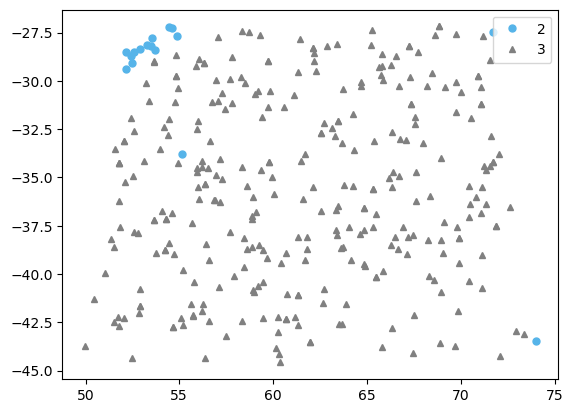

In [25]:
color_truth_type = {2 : '#56b4e9', 3 : 'grey'}
marker_truth_type = {2 : 'o', 3 : '^'}

groups = df_merged.groupby('truth_type')
for name, group in groups:
    plt.plot(group.ra_x, group.decl, marker=marker_truth_type[name], linestyle='', markersize=5, label=name, color=color_truth_type[name])

plt.legend()

Now, let's calcuate the separation in arcseconds between each DiaObject in the merged DataFrame and its TruthSummary match.  We could do this with `astropy`, but here we will just do a quick calculation using the following function.

(Alternatively, we could have just used the results from `idx, d2d, d3d = match_coordinates_sky(c_df_DiaObjs_tx, c_ts23)`, via `df_merged['d2d_arcsec'] = d2d.arcsec`.  Note that the results from `match_coordinates_sky` differ from those from the following `sepGetArray` function by c. 1 milli-arcsec.)

In [26]:
# Return angular separation (in degrees) of two points on the Celestial Sphere
def sepDegGetArray(raDeg1,decDeg1,raDeg2,decDeg2):

    import numpy

    raRad1  = numpy.radians(raDeg1)
    decRad1 = numpy.radians(decDeg1)
    raRad2  = numpy.radians(raDeg2)
    decRad2 = numpy.radians(decDeg2)

    cosSep = numpy.sin(decRad1)*numpy.sin(decRad2) + numpy.cos(decRad1)*numpy.cos(decRad2)*numpy.cos(raRad1-raRad2)
    sepRad = numpy.arccos(cosSep)
    sepDeg = numpy.degrees(sepRad)

    return sepDeg

In [27]:
df_merged['sepArcsec'] = 3600.*sepDegGetArray(df_merged['ra_x'],df_merged['decl'],df_merged['ra_y'],df_merged['dec'])

In [28]:
df_merged

,ra_x,decl,diaObjectId,nDiaSources,rMagMax,rMagMin,gMagMin,iMagMin,rMagAmp,min,...,duration,id,ra_y,dec,is_pointsource,is_variable,mag_r,redshift,truth_type,sepArcsec
0,69.702484,-43.750691,1252765956501932725,19,23.845530,21.948813,22.965589,22.228006,1.896717,60539.352055,...,65.996704,MS_10451_93,69.702470,-43.750685,1,1,NaN,0.242086,3,0.043900
1,57.485425,-43.197181,1250303050455712759,19,24.429010,22.133767,23.168029,22.127754,2.295243,60147.390471,...,86.746943,MS_10323_319,57.485420,-43.197179,1,1,NaN,0.360101,3,0.015057
2,60.264618,-43.005713,1327084146446570130,28,23.604461,21.935938,22.368122,22.002965,1.668523,60949.274102,...,67.986160,MS_10324_439,60.264624,-43.005710,1,1,NaN,0.410997,3,0.019919
3,56.375996,-44.369969,1250030371572026200,43,23.883358,20.458851,23.080142,20.916062,3.424507,60905.284060,...,58.907399,MS_10323_18,56.375994,-44.369965,1,1,NaN,0.120062,3,0.013040
4,68.880903,-43.571043,1252792344780999776,21,24.225392,22.215730,22.887685,22.219647,2.009662,60559.295997,...,51.949421,MS_10327_219,68.880893,-43.571047,1,1,NaN,0.320625,3,0.029958
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
326,52.163669,-28.483417,2089863741146401239,23,23.972337,22.304456,22.522794,22.185417,1.667881,60498.401171,...,59.930760,1568705154,52.194714,-29.752989,1,1,20.4611,0.000000,2,4571.500483
327,71.071491,-30.300366,2003618049063651536,17,24.027688,21.798445,22.335811,22.448220,2.229242,60530.354183,...,62.914389,MS_9177_65,71.071475,-30.300371,1,1,NaN,0.238924,3,0.053766
328,60.368959,-44.582947,1250830816037045527,19,23.532240,21.099157,21.811210,21.606542,2.433083,61050.154981,...,69.871517,MS_10448_78,60.368952,-44.582944,1,1,NaN,0.236637,3,0.020388
329,67.457963,-44.080243,1252220598734556212,28,23.793173,21.620125,22.077266,21.674331,2.173048,60937.256126,...,66.815936,MS_10450_185,67.457959,-44.080243,1,1,NaN,0.311978,3,0.013040


Now let's plot the histogram of separations.  There are clearly some "matches" that have a separation over a degree away!

Text(0, 0.5, 'Number')

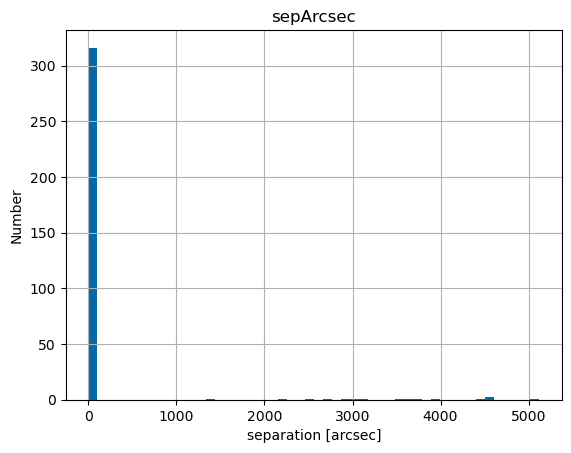

In [29]:
df_merged.hist('sepArcsec', bins=50)
plt.xlabel('separation [arcsec]')
plt.ylabel('Number')

Let's plot DiaObjects matched with TruthSummary variable stars separately from those matched with TruthSummary SNe Ia.

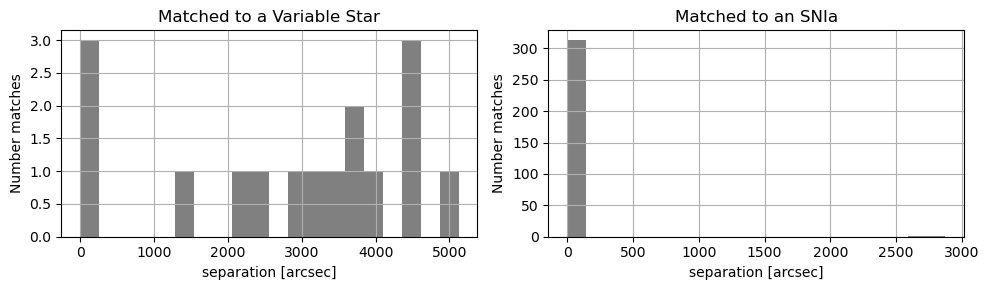

In [30]:
fig, ax = plt.subplots(1, 2, figsize=(10, 3), sharey=False, sharex=False)

ax[0].hist(df_merged[df_merged.truth_type==2]['sepArcsec'], bins=20, color='grey')
ax[0].set_title('Matched to a Variable Star')
ax[0].set_xlabel('separation [arcsec]')
ax[0].set_ylabel('Number matches')
ax[0].grid(True)

ax[1].hist(df_merged[df_merged.truth_type==3]['sepArcsec'], bins=20, color='grey')
ax[1].set_title('Matched to an SNIa')
ax[1].set_xlabel('separation [arcsec]')
ax[1].set_ylabel('Number matches')
ax[1].grid(True)

plt.tight_layout()
plt.show()

Let's zoom in for both of these...

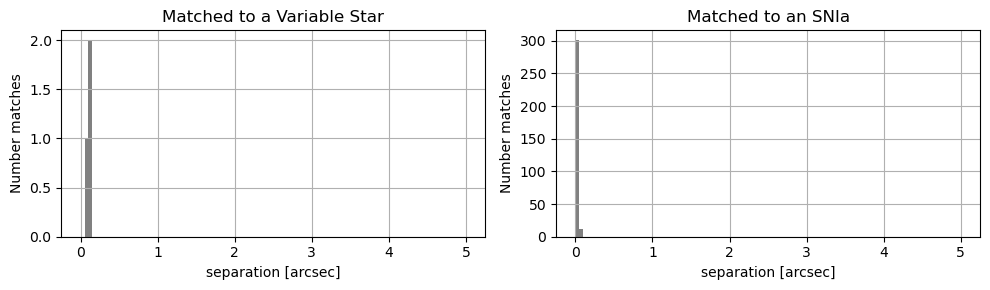

In [31]:
# Limit ot a range of 5.00 arcsec:
range = [0.00, 5.00]

fig, ax = plt.subplots(1, 2, figsize=(10, 3), sharey=False, sharex=False)

ax[0].hist(df_merged[df_merged.truth_type==2]['sepArcsec'], bins=100, range=range, color='grey')
ax[0].set_title('Matched to a Variable Star')
ax[0].set_xlabel('separation [arcsec]')
ax[0].set_ylabel('Number matches')
ax[0].grid(True)

ax[1].hist(df_merged[df_merged.truth_type==3]['sepArcsec'], bins=100, range=range, color='grey')
ax[1].set_title('Matched to an SNIa')
ax[1].set_xlabel('separation [arcsec]')
ax[1].set_ylabel('Number matches')
ax[1].grid(True)

plt.tight_layout()
plt.show()

Zoom in even more...

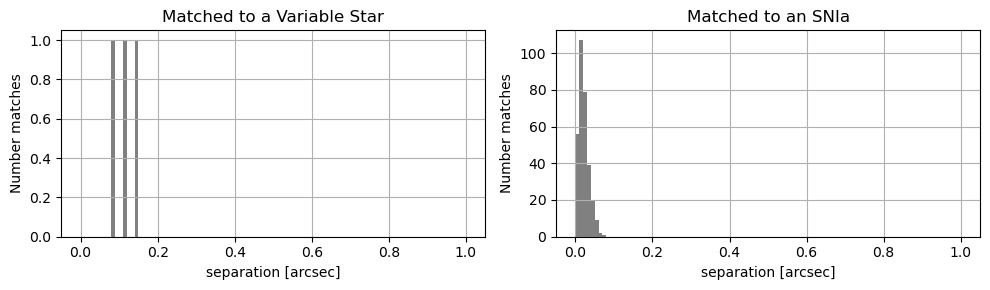

In [32]:
# Limit ot a range of 1.00 arcsec:
range = [0.00, 1.00]

fig, ax = plt.subplots(1, 2, figsize=(10, 3), sharey=False, sharex=False)

ax[0].hist(df_merged[df_merged.truth_type==2]['sepArcsec'], bins=100, range=range, color='grey')
ax[0].set_title('Matched to a Variable Star')
ax[0].set_xlabel('separation [arcsec]')
ax[0].set_ylabel('Number matches')
ax[0].grid(True)

ax[1].hist(df_merged[df_merged.truth_type==3]['sepArcsec'], bins=100, range=range, color='grey')
ax[1].set_title('Matched to an SNIa')
ax[1].set_xlabel('separation [arcsec]')
ax[1].set_ylabel('Number matches')
ax[1].grid(True)

plt.tight_layout()
plt.show()

Hmmm...  A match radius of 1.00 arcsec seems reasonable.  It tooks like three legitimate matches between the SNIa-candidate DiaObjects and variable stars out of a total of 331 SNIa-candidate DiaObjects.  The overwhelming majority of SNIa-candidate DiaObjects (313 out of 331) are matched to genuine SNeIa's in the TruthSummary table:

In [33]:
len( df_merged[ (df_merged.truth_type==3) & (df_merged.sepArcsec < 1.00) ]['sepArcsec'] )

313

Let's plot the sky distribution of again, but color-code the symbols by `sepArcsec`.  It is clear here that the stars in the upper right of the plot are all bad matches.

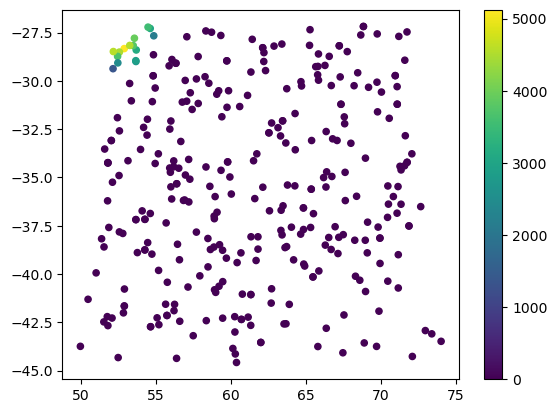

In [34]:
plt.scatter(df_merged.ra_x, df_merged.decl, marker='o', s=20, c=df_merged.sepArcsec)
plt.colorbar()


Finally, for this subsection, let's plot the redshifts of the 313 DiaObjects are well-matched with SNeIa in the TruthSummary table.  

array([[<AxesSubplot:title={'center':'redshift'}>]], dtype=object)

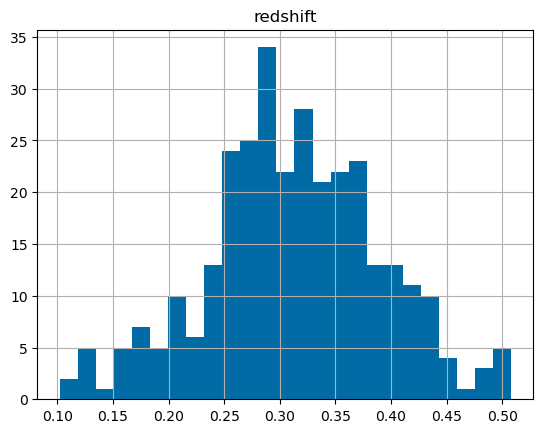

In [35]:
mask = (df_merged.truth_type==3) & (df_merged.sepArcsec < 1.00)
df_merged[mask].hist('redshift', bins=25)

## 3.  What fraction of variable objects in the TruthSummary table show up in the DiaObject table?

This is sort of the reverse question from the one in Section 2.  

There, we extracted a set of candidate SNe Ia from the DiaObjects table using the observed properties from the DiaObject and DiaSource tables and tried to find their matches in the TruthSummary table.

Here, we are looking at the TruthSummary table, and want to see if the variable objects found there can also be found in thd DiaObjects table.  (We don't expect all the entries in the TruthSummary table to have corresponding entries in the DiaObject table, since the TruthSummmary table goes deeper than the Rubin detection thresholds.)

First, let's grab an RA,DEC-restricted sample of variable objects from the TruthSummary table.  This typically takes less than a minute.

In [36]:
%%time
# This cell takes several minutes to run...

query = """SELECT id, ra, dec, is_variable, mag_r, redshift, truth_type 
           FROM dp02_dc2_catalogs.TruthSummary 
           WHERE ra >= 61.0 AND ra <= 62.0 AND dec >= -33.0 AND dec <= -32.0
           AND is_variable=1
        """

print(query)

results = service.search(query)
df_ts123 = results.to_table().to_pandas()
del results

df_ts123

SELECT id, ra, dec, is_variable, mag_r, redshift, truth_type 
           FROM dp02_dc2_catalogs.TruthSummary 
           WHERE ra >= 61.0 AND ra <= 62.0 AND dec >= -33.0 AND dec <= -32.0
           AND is_variable=1
        
CPU times: user 199 ms, sys: 19.1 ms, total: 218 ms
Wall time: 1min 15s


,id,ra,dec,is_variable,mag_r,redshift,truth_type
0,31405809473,61.919783,-32.871835,1,27.697901,0.0,2
1,31405828721,61.967676,-32.997044,1,23.061899,0.0,2
2,31405810343,61.986806,-32.872076,1,24.902901,0.0,2
3,31405809928,61.961171,-32.871386,1,24.534500,0.0,2
4,30825475570,61.923676,-32.869791,1,25.080099,0.0,2
...,...,...,...,...,...,...,...
11320,30317269522,61.763840,-32.672447,1,25.792601,0.0,2
11321,30317269554,61.766931,-32.678175,1,20.691500,0.0,2
11322,31102029271,61.764857,-32.677272,1,25.427601,0.0,2
11323,31405782325,61.774600,-32.696704,1,22.365299,0.0,2


It looks like there are a lot of variable stars (`truth_type=2`).  

Let's now create a SkyCoord array for these objects, to be used in later matching.

In [37]:
c_ts123 = SkyCoord(ra=df_ts123.loc[:,'ra'].values*u.degree, dec=df_ts123.loc[:,'dec'].values*u.degree)

Next, we will query all the objects in the DiaObject table within the same RA,DEC range.  (Although we use `maxrec`, this limit is actually not reached.  In the RA,DEC range used, there are 100,643 entries returned.)  The query is similar for the DiaObjs query in Section 3.2, but with fewer restrictions in the `WHERE` clause.  Basically, we wanted just about everything in the DiaObjects table within a limited RA,DEC range.  The following cell typically takes less than a minute to run.

In [51]:
%%time

results = service.search("SELECT ra, decl, diaObjectId, nDiaSources, "
                         "scisql_nanojanskyToAbMag(rPSFluxMin) AS rMagMax, "
                         "scisql_nanojanskyToAbMag(rPSFluxMax) AS rMagMin, "
                         "scisql_nanojanskyToAbMag(gPSFluxMax) AS gMagMin, "
                         "scisql_nanojanskyToAbMag(iPSFluxMax) AS iMagMin, "
                         "scisql_nanojanskyToAbMag(rPSFluxMin)"
                         " - scisql_nanojanskyToAbMag(rPSFluxMax) AS rMagAmp "
                         "FROM dp02_dc2_catalogs.DiaObject "
                         "WHERE ra BETWEEN 61.0 AND 62.0 AND decl BETWEEN -33.0 AND -32.0",
                         maxrec=1000000)

DiaObjsAll = results.to_table()
del results

CPU times: user 1.87 s, sys: 19.9 ms, total: 1.89 s
Wall time: 9.36 s


In [52]:
DiaObjsAll

ra,decl,diaObjectId,nDiaSources,rMagMax,rMagMin,gMagMin,iMagMin,rMagAmp
deg,deg,,,,,,,
float64,float64,int64,int64,float64,float64,float64,float64,float64
61.316348,-32.1466432,1911223887958379717,1,--,--,--,--,--
61.4387331,-32.1017852,1911223887958379713,1,--,--,--,--,--
61.3903025,-32.1301004,1911223887958379716,1,--,--,--,--,--
61.3541082,-32.1102304,1911223887958379724,1,--,--,--,23.793947887695367,--
61.356845,-32.1213664,1911223887958379725,1,--,--,--,23.779834805675634,--
61.4318524,-32.2892999,1911223887958379752,1,--,--,--,--,--
61.4282789,-32.1379358,1911223887958379753,1,--,--,--,--,--
61.4441638,-32.1100087,1911223887958379754,1,--,--,--,--,--


Let's convert the `astropy` table to a pandas DataFrame.

In [54]:
df_DiaObjsAll = DiaObjsAll.to_pandas()

... and create a SkyCoord array for matching...

In [55]:
c_df_DiaObjsAll = SkyCoord(ra=df_DiaObjsAll.loc[:,'ra'].values*u.degree, dec=df_DiaObjsAll.loc[:,'decl'].values*u.degree)

And perform the match, finding the best match in c_df_DiaObjsAll for each row in c_ts123...

In [56]:
idx, d2d, d3d = match_coordinates_sky(c_ts123, c_df_DiaObjsAll)

In [57]:
len(idx)

11325

Let's look at the distribution of separations.

(array([4.224e+03, 2.786e+03, 2.331e+03, 1.309e+03, 5.330e+02, 1.200e+02,
        1.800e+01, 3.000e+00, 0.000e+00, 1.000e+00]),
 array([3.60000015e-04, 3.64820078e+00, 7.29604157e+00, 1.09438824e+01,
        1.45917231e+01, 1.82395639e+01, 2.18874047e+01, 2.55352455e+01,
        2.91830863e+01, 3.28309271e+01, 3.64787678e+01]),
 <BarContainer object of 10 artists>)

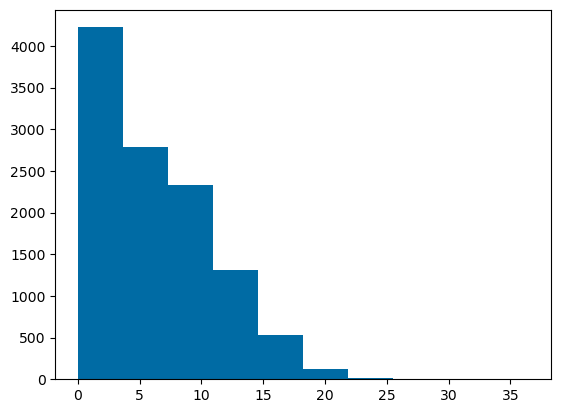

In [58]:
plt.hist(d2d.arcsec)

Hmmm...  Lots of separations >> 1 arcsec.  Probably a lot of mismatches.  Let's also look at the distribution of nDiaSources for the matches.

(array([0.0000e+00, 8.3217e+04, 4.9100e+03, 1.7930e+03, 1.2070e+03,
        9.5700e+02, 7.5400e+02, 6.9400e+02, 6.3100e+02, 5.2500e+02,
        4.5900e+02, 3.8600e+02, 3.6500e+02, 3.3000e+02, 2.4600e+02,
        2.4300e+02, 2.3600e+02, 2.0900e+02, 1.6300e+02, 1.3800e+02,
        1.3700e+02, 1.0500e+02, 9.7000e+01, 9.3000e+01, 8.1000e+01,
        6.7000e+01, 6.5000e+01, 7.8000e+01, 8.6000e+01, 6.5000e+01,
        5.0000e+01, 6.2000e+01, 6.5000e+01, 5.1000e+01, 6.4000e+01,
        5.1000e+01, 5.0000e+01, 5.4000e+01, 5.3000e+01, 5.4000e+01,
        3.3000e+01, 4.4000e+01, 4.0000e+01, 3.8000e+01, 3.5000e+01,
        3.6000e+01, 4.5000e+01, 2.4000e+01, 3.5000e+01, 2.9000e+01,
        2.3000e+01, 2.6000e+01, 2.3000e+01, 2.5000e+01, 2.3000e+01,
        2.1000e+01, 1.4000e+01, 2.4000e+01, 2.2000e+01, 2.6000e+01,
        2.1000e+01, 2.3000e+01, 1.9000e+01, 1.2000e+01, 9.0000e+00,
        1.2000e+01, 1.1000e+01, 6.0000e+00, 8.0000e+00, 1.4000e+01,
        1.6000e+01, 1.2000e+01, 1.1000e+01, 1.90

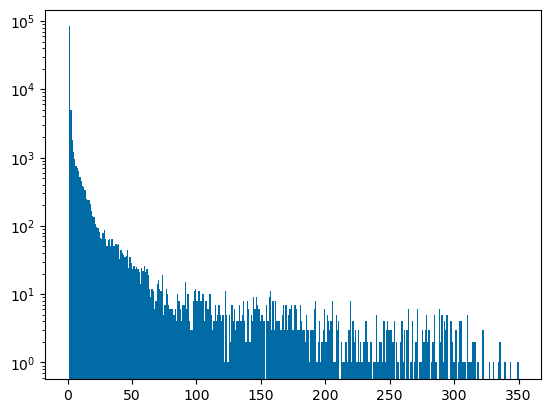

In [59]:
plt.hist(df_DiaObjsAll.nDiaSources, bins=350, range=(0.0,350), log=True)

Based upon our results from Section 2, let us assume that matches with `sepArcsec` > 1.00 arcsec are bad matches.

How many good matches remain? How many bad matches are there?

In [62]:
d2d.arcsec<=1.00

array([False, False, False, ..., False, False, False])

In [47]:
d2d.arcsec>1.00

array([ True,  True,  True, ...,  True,  True,  True])

In [48]:
# Let's restrict the max match radius to 1 arcsec...
max_sep = 1.0 * u.arcsec
sep_constraint = d2d < max_sep
c_ts23_matches = c_ts23[sep_constraint]
c_df_DiaObjs_tx_matches = c_df_DiaObjs_tx[idx[sep_constraint]]

IndexError: boolean index did not match indexed array along dimension 0; dimension is 5321710 but corresponding boolean dimension is 11325

In [ ]:
print(len(c_ts23_matches), len(c_df_DiaObjs_tx_matches))

In [ ]:
c_ts23_matches

In [ ]:
c_df_DiaObjs_tx_matches

In [ ]:
df_DiaObjs_tx.loc[idx[sep_constraint]]

In [ ]:
df_ts23

In [ ]:
df_DiaObjs_tx.loc[idx]

In [ ]:
df_do_new = df_do.loc[idx].copy(deep=True)

In [ ]:
df_do_new.reset_index(inplace=True)

In [ ]:
df_do_new